<a href="https://colab.research.google.com/github/JunyiJ/DeepGenerativeModels/blob/master/ConditionalFlowMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [ ]:
%pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchdiffeq

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import numpy as np
import pickle
import itertools
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# b. MNIST Data Loader

In [ ]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.13MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 59.1kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **1. Class Conditional Flow Matching**

# a. Building Blocks

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
          x1 = self.conv1(x)
          x2 = self.conv2(x1)
          if self.same_channels:
              out = x + x2
          else:
              out = x1 + x2
          return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(UNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1 + temb1, down2)
        up3 = self.up2(up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# b. Optimal Transport Conditional Vector Fields

In [ ]:
def pad_t_like_x(t, x):
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    def __init__(self, sigma = 0.0):
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        return t * x1 + (1-t) * x0

    def compute_sigma_t(self, t):
        return 1 - t

    def compute_conditional_flow(self, x0, x1, t, xt):
        return (x1 - xt) / (1-t)

    def sample_xt(self, x0, x1, t, epsilon):
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        xt = mu_t + sigma_t * epsilon
        return xt


    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"
        t = t.reshape(-1, 1, 1, 1)

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

# c. Training Functions

In [ ]:
def train_main_loop(n_epochs, optimizer, FM, model):
  for epoch in range(n_epochs):
      print(f'epoch {epoch}')
      pbar = tqdm(train_loader)
      for i, data in enumerate(pbar):
          optimizer.zero_grad()
          x1 = data[0].to(device)
          x0 = torch.randn_like(x1)
          t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
          vt = model(xt, t)
          loss = torch.mean((vt - ut) ** 2)
          loss.backward()
          optimizer.step()
          pbar.set_description(f"loss: {loss.item():.4f}")

      with torch.no_grad():
          traj = torchdiffeq.odeint(
              lambda t, x: model.forward(x, t),
              torch.randn(100, 1, 28, 28, device=device),
              torch.linspace(0, 1, 2, device=device),
              atol=1e-4,
              rtol=1e-4,
              method="dopri5",
          )

      grid = make_grid(
          traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
      )

      img = ToPILImage()(grid)
      plt.imshow(img)
      plt.show()

# e. Training


epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]

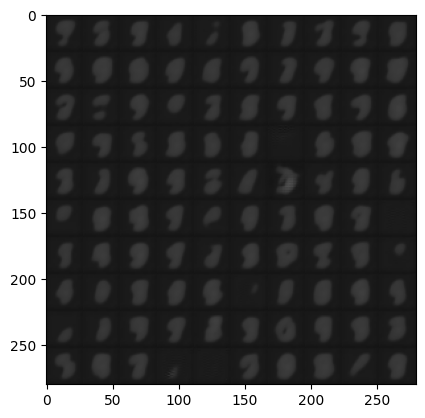

epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

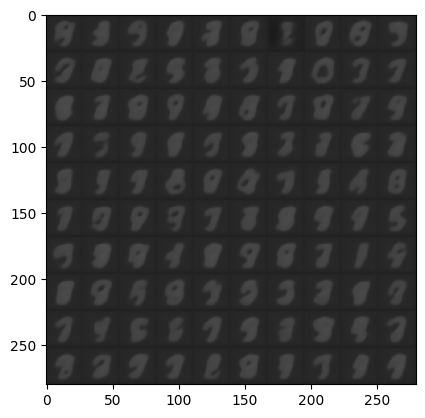

epoch 2


  0%|          | 0/235 [00:00<?, ?it/s]

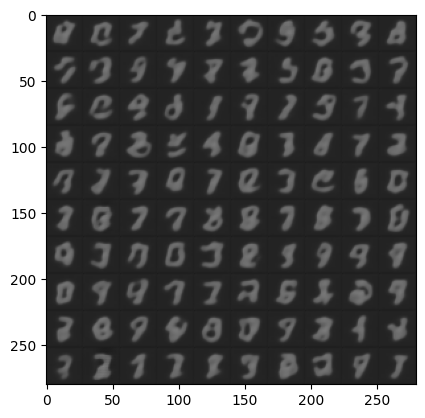

epoch 3


  0%|          | 0/235 [00:00<?, ?it/s]

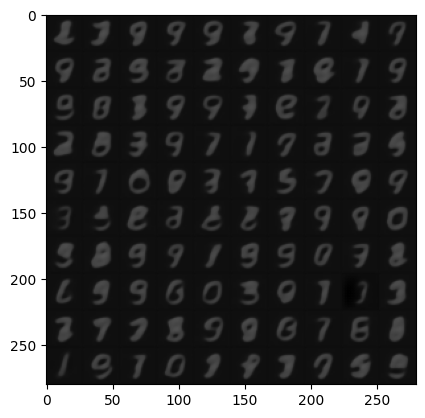

epoch 4


  0%|          | 0/235 [00:00<?, ?it/s]

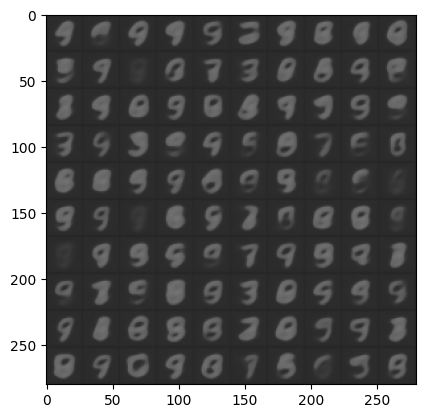

epoch 5


  0%|          | 0/235 [00:00<?, ?it/s]

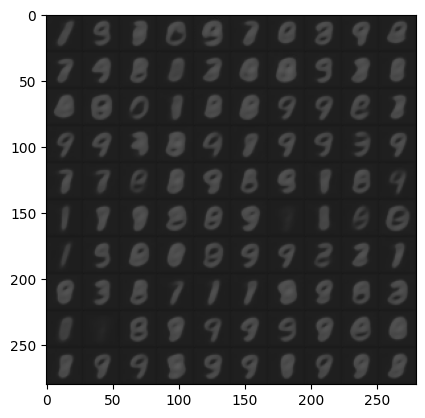

epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]

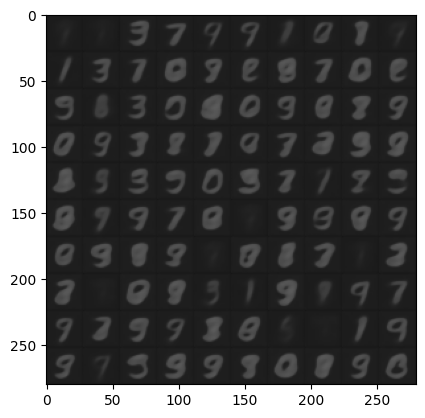

epoch 7


  0%|          | 0/235 [00:00<?, ?it/s]

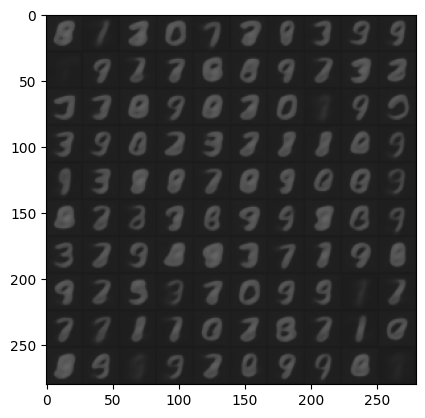

epoch 8


  0%|          | 0/235 [00:00<?, ?it/s]

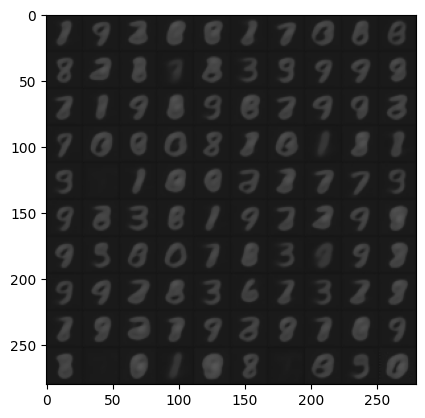

epoch 9


  0%|          | 0/235 [00:00<?, ?it/s]

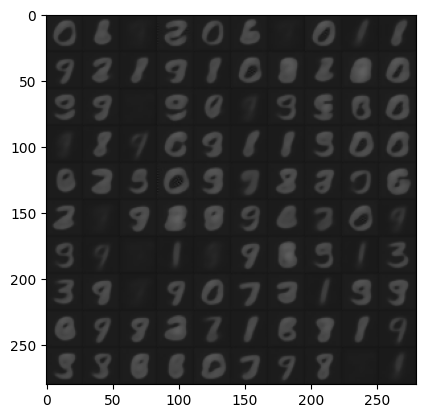

In [ ]:
sigma = 0.0
n_feat = 128
n_epochs = 10

model = UNet(in_channels=1, n_feat=n_feat, n_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = ConditionalFlowMatcher(sigma=sigma)

train_main_loop(n_epochs, optimizer, FM, model)
